In [1]:
import pylcp
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants as const
from sympy.physics.wigner import wigner_3j, wigner_6j, wigner_9j
import time
import pathos

In [2]:
atom = pylcp.atom('87Rb')
# gamma = 2*np.pi*5.75e6 # Hz
# k = 2*np.pi/794.97851156 # m^-1
gamma = 2*np.pi*atom.state[1].gammaHz # Hz
k = 2*np.pi/794.97851156e-9 # m^-1

t_unit = 1/gamma
#t_unit = 1e-1

m_unit = 1/k
#m_unit = 1e-9

velocity_unit = m_unit/t_unit
accel_unit = m_unit/t_unit**2
Hz_unit = 1/t_unit
Js_unit = const.hbar # kg m^2/s
mass_unit = Js_unit*t_unit/m_unit**2
HzperT_unit = const.value("Bohr magneton")/(Js_unit)
T_unit = Hz_unit/HzperT_unit
amu_unit = mass_unit/1.66e-27
cm_unit = m_unit/1e-2
F_unit = mass_unit*m_unit/t_unit**2
I_sat = (np.pi*const.h*const.c*gamma)/(3*(2*np.pi/k)**3) # W/m^2

In [3]:
print(t_unit)
print(cm_unit)
print(velocity_unit)
print(accel_unit)

2.7679000000000003e-08
1.2652475976661148e-05
4.571146348011542
165148536.72500962


In [4]:
ksim=k*m_unit
gammasim=gamma/Hz_unit
print(ksim)
print(gammasim)

1.0
1.0


In [5]:
delta_0 = 150e6

Hg1, mu_qg1 = pylcp.hamiltonians.singleF(1, -1/2, 1)
Hg2, mu_qg2 = pylcp.hamiltonians.singleF(2,  1/2, 1)
He2, mu_qe2 = pylcp.hamiltonians.singleF(2,  1/6, 1)
dijq_g1e2 = pylcp.hamiltonians.dqij_two_bare_hyperfine(1,2)
dijq_g2e2 = pylcp.hamiltonians.dqij_two_bare_hyperfine(2,2)

In [6]:
mu_q = {}
d_q = {}
H0 = {}

In [7]:
H0['g1'] = Hg1
H0['g2'] = Hg2
H0['e2'] = He2 - np.eye(5)*delta_0*2*np.pi/Hz_unit

mu_q['g1'] = mu_qg1
mu_q['g2'] = mu_qg2
mu_q['e2'] = mu_qe2

d_q[('g1','e2')] = dijq_g1e2
d_q[('g2','e2')] = dijq_g2e2

In [8]:
Hg, mu_qg = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[0].J, atom.I, atom.state[0].gJ, atom.gI,
    atom.state[0].Ahfs*2*np.pi/Hz_unit, Bhfs=0, Chfs=0,
    muB=1)
He, mu_qe = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[1].J, atom.I, atom.state[1].gJ, atom.gI,
    atom.state[1].Ahfs*2*np.pi/Hz_unit, Bhfs=0, Chfs=0,
    muB=1)
dijq = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(
    atom.state[0].J, atom.state[1].J, atom.I)

Ee = np.unique(np.diagonal(He))*Hz_unit/2/np.pi
Eg = np.unique(np.diagonal(Hg))*Hz_unit/2/np.pi

print(Eg)
print(Ee)

[-4.27167663e+09  2.56300598e+09]
[-5.0905e+08  3.0543e+08]


In [9]:
mag_field = pylcp.fields.quadrupoleMagneticField(110*1e-4*cm_unit*HzperT_unit/Hz_unit)
no_mag_field = pylcp.fields.quadrupoleMagneticField(0*1e-4*cm_unit*HzperT_unit/Hz_unit)

In [10]:
Ee

array([-5.0905e+08,  3.0543e+08])

In [11]:
hamiltonian = pylcp.hamiltonian(Hg, He, mu_qg, mu_qe, dijq, mass = 87/amu_unit, k = ksim, gamma = gammasim)

In [12]:
hamiltonian_split = pylcp.hamiltonian(mass=87/amu_unit, k=ksim, gamma=gammasim)
[hamiltonian_split.add_H_0_block(l, H) for l, H in H0.items()]
[hamiltonian_split.add_mu_q_block(l, mu, muB=1) for l, mu in mu_q.items()]
[hamiltonian_split.add_d_q_block(l[0],l[1], dq, k=ksim, gamma=gammasim) for l, dq in d_q.items()]
hamiltonian_split.print_structure()

[[((<g1|H_0|g1> 3x3), (<g1|mu_q|g1> 3x3)) None (<g1|d_q|e2> 3x5)]
 [None ((<g2|H_0|g2> 5x5), (<g2|mu_q|g2> 5x5)) (<g2|d_q|e2> 5x5)]
 [(<e2|d_q|g1> 5x3) (<e2|d_q|g2> 5x5)
  ((<e2|H_0|e2> 5x5), (<e2|mu_q|e2> 5x5))]]


In [13]:
def MOT_Beams(delta_1, delta_2, *args):

    lasers  = pylcp.laserBeams()
    lasers += pylcp.laserBeams([
        {'kvec':np.array([-1, 0, 0.])*ksim, 'pol':1, 'delta':2*np.pi*(-Eg[1]+Ee[1]+delta_1)/Hz_unit, 's':1, 'wb':1/cm_unit},
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':1, 'delta':2*np.pi*(-Eg[1]+Ee[1]+delta_1)/Hz_unit, 's':1, 'wb':1/cm_unit},
        {'kvec':np.array([0, -1, 0.])*ksim, 'pol':1, 'delta':2*np.pi*(-Eg[1]+Ee[1]+delta_1)/Hz_unit, 's':1, 'wb':1/cm_unit},
        {'kvec':np.array([0, 1, 0.])*ksim, 'pol':1, 'delta':2*np.pi*(-Eg[1]+Ee[1]+delta_1)/Hz_unit, 's':1, 'wb':1/cm_unit},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':-1, 'delta':2*np.pi*(-Eg[1]+Ee[1]+delta_1)/Hz_unit, 's':1, 'wb':1/cm_unit},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':-1, 'delta':2*np.pi*(-Eg[1]+Ee[1]+delta_1)/Hz_unit, 's':1, 'wb':1/cm_unit}
    ], beam_type=pylcp.gaussianBeam)
    lasers +=  pylcp.laserBeams([
        {'kvec':np.array([-1, 0, 0.])*ksim, 'pol':1, 'delta':2*np.pi*(-Eg[0]+Ee[1]+delta_1+delta_2)/Hz_unit, 's':1, 'wb':1/cm_unit},
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':1, 'delta':2*np.pi*(-Eg[0]+Ee[1]+delta_1+delta_2)/Hz_unit, 's':1, 'wb':1/cm_unit},
        {'kvec':np.array([0, -1, 0.])*ksim, 'pol':1, 'delta':2*np.pi*(-Eg[0]+Ee[1]+delta_1+delta_2)/Hz_unit, 's':1, 'wb':1/cm_unit},
        {'kvec':np.array([0, 1, 0.])*ksim, 'pol':1, 'delta':2*np.pi*(-Eg[0]+Ee[1]+delta_1+delta_2)/Hz_unit, 's':1, 'wb':1/cm_unit},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':-1, 'delta':2*np.pi*(-Eg[0]+Ee[1]+delta_1+delta_2)/Hz_unit, 's':1, 'wb':1/cm_unit},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':-1, 'delta':2*np.pi*(-Eg[0]+Ee[1]+delta_1+delta_2)/Hz_unit, 's':1, 'wb':1/cm_unit}
    ], beam_type=pylcp.gaussianBeam)
    return lasers

def MOT_Beams_split_H(delta_1, delta_2, *args):

    return {
        'g2->e2' : pylcp.laserBeams([
        {'kvec':np.array([-1, 0, 0.])*ksim, 'pol':1, 'delta':2*np.pi*(delta_1-delta_0)/Hz_unit, 's':1},
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':1, 'delta':2*np.pi*(delta_1-delta_0)/Hz_unit, 's':1},
        {'kvec':np.array([0, -1, 0.])*ksim, 'pol':1, 'delta':2*np.pi*(delta_1-delta_0)/Hz_unit, 's':1},
        {'kvec':np.array([0, 1, 0.])*ksim, 'pol':1, 'delta':2*np.pi*(delta_1-delta_0)/Hz_unit, 's':1},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':-1, 'delta':2*np.pi*(delta_1-delta_0)/Hz_unit, 's':1},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':-1, 'delta':2*np.pi*(delta_1-delta_0)/Hz_unit, 's':1}
    ], beam_type=pylcp.infinitePlaneWaveBeam),
        'g1->e2' : pylcp.laserBeams([
        {'kvec':np.array([-1, 0, 0.])*ksim, 'pol':1, 'delta':2*np.pi*(delta_1+delta_2-delta_0)/Hz_unit, 's':1},
        {'kvec':np.array([1, 0, 0.])*ksim, 'pol':1, 'delta':2*np.pi*(delta_1+delta_2-delta_0)/Hz_unit, 's':1},
        {'kvec':np.array([0, -1, 0.])*ksim, 'pol':1, 'delta':2*np.pi*(delta_1+delta_2-delta_0)/Hz_unit, 's':1},
        {'kvec':np.array([0, 1, 0.])*ksim, 'pol':1, 'delta':2*np.pi*(delta_1+delta_2-delta_0)/Hz_unit, 's':1},
        {'kvec':np.array([0., 0.,  1.])*ksim, 'pol':-1, 'delta':2*np.pi*(delta_1+delta_2-delta_0)/Hz_unit, 's':1},
        {'kvec':np.array([0., 0., -1.])*ksim, 'pol':-1, 'delta':2*np.pi*(delta_1+delta_2-delta_0)/Hz_unit, 's':1}
    ], beam_type=pylcp.infinitePlaneWaveBeam)}

In [14]:
150*k/gamma

32.814525849790456

Completed in 0.21 s.                                              


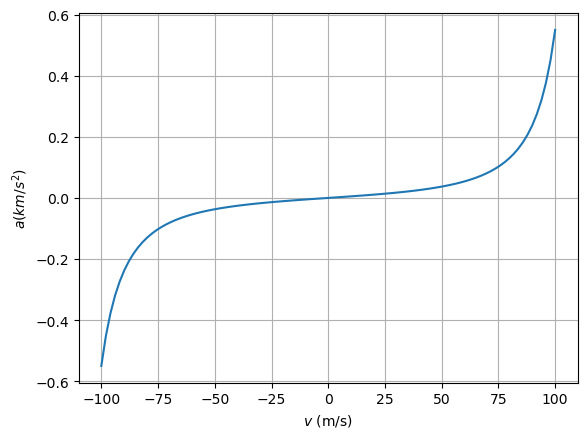

In [31]:
rateeq = pylcp.rateeq(MOT_Beams(150e6,0e6), mag_field, hamiltonian,include_mag_forces=False)

R = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-100/velocity_unit, 100/velocity_unit, 100)

rateeq.generate_force_profile([np.zeros(v.shape),np.zeros(v.shape),np.zeros(v.shape)],
                              [v,np.zeros(v.shape),np.zeros(v.shape)],
                           name='Frad', progress_bar=True)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(v*velocity_unit, rateeq.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

Completed in 1.65 s.                                               


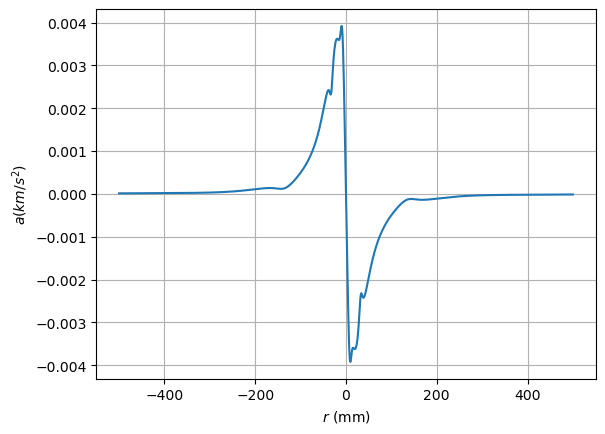

In [32]:
rateeq = pylcp.rateeq(MOT_Beams(150e6,0e6), mag_field, hamiltonian,include_mag_forces=False)

r = np.linspace(-50/cm_unit, 50/cm_unit, 1000)
v = np.linspace(-10/velocity_unit, 10/velocity_unit, 100)

rateeq.generate_force_profile([r,np.zeros(r.shape),np.zeros(r.shape)],
                              [np.zeros(r.shape),np.zeros(r.shape),np.zeros(r.shape)],
                           name='Frad', progress_bar=True)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(r*cm_unit*10, rateeq.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$r$ (mm)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

Completed in 0.97 s.                                               


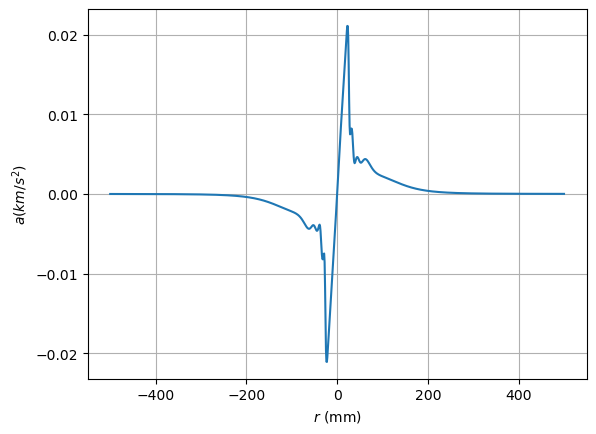

In [20]:
rateeq = pylcp.rateeq(MOT_Beams_split_H(150e6,0e6), mag_field, hamiltonian_split,include_mag_forces=False)

r = np.linspace(-50/cm_unit, 50/cm_unit, 1000)
v = np.linspace(-10/velocity_unit, 10/velocity_unit, 100)

rateeq.generate_force_profile([r,np.zeros(r.shape),np.zeros(r.shape)],
                              [np.zeros(r.shape),np.zeros(r.shape),np.zeros(r.shape)],
                           name='Frad', progress_bar=True)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(r*cm_unit*10, rateeq.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$r$ (mm)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

In [16]:
150e6*2*np.pi/gamma

26.086842917613566

In [33]:
obe_kwargs = dict(itermax=200, rel=1e-7, abs=0, #deltat_func = lambda r, v : 1/gammasim+0*(1/gammasim if ksim/abs(v[0]) < 1/gammasim else 2*np.pi/ksim/abs(v[0])), deltat_r=np.inf,
                  deltat_tmax = 50/gammasim, deltat_r=np.inf,
                  Npts=5001, debug = False, rtol=1e-7, reset_pos = True,
                  atol=np.concatenate(([1e-5]*13*13,[1/velocity_unit,1/velocity_unit,1/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])))

In [34]:
obe = pylcp.obe(MOT_Beams(150e6,10e6), mag_field, hamiltonian,include_mag_forces=False, transform_into_re_im=False)

In [18]:
50/gamma

1.3839500000000001e-06

In [19]:
r = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-300/velocity_unit, 300/velocity_unit, 100)

obe.generate_force_profile([r,np.zeros(r.shape),np.zeros(r.shape)],
                           [np.zeros(r.shape),np.zeros(r.shape),np.zeros(r.shape)],
                           name='Frad', progress_bar=True, **obe_kwargs)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(r*cm_unit*10, obe.profile['Frad'].F[0]*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$r$ (mm)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

KeyboardInterrupt: 

Completed in 21:15:43.                                               


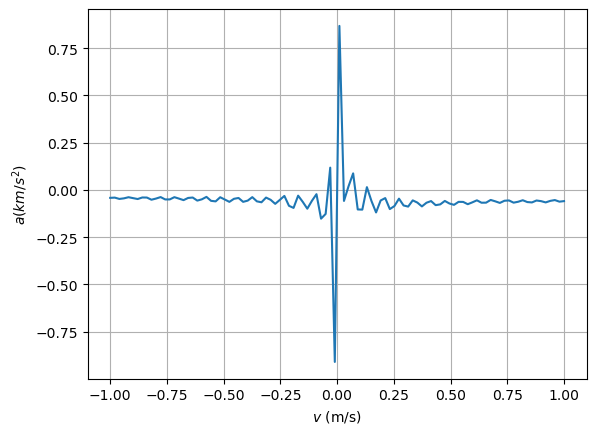

In [20]:
obe = pylcp.obe(MOT_Beams_split_H(150e6,0e6), mag_field, hamiltonian_split,include_mag_forces=False, transform_into_re_im=False)
R = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-1/velocity_unit, 1/velocity_unit, 100)

obe.generate_force_profile([np.zeros(v.shape),np.zeros(v.shape),np.zeros(v.shape)],
                              [v,np.zeros(v.shape),np.zeros(v.shape)],
                           name='Frad2', progress_bar=True, **obe_kwargs)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(v*velocity_unit, obe.profile['Frad2'].F[0]*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

In [35]:
obe = pylcp.obe(MOT_Beams_split_H(150e6,10e6), mag_field, hamiltonian_split,include_mag_forces=False, transform_into_re_im=False)
R = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-1/velocity_unit, 1/velocity_unit, 100)

obe.generate_force_profile([np.zeros(v.shape),np.zeros(v.shape),np.zeros(v.shape)],
                              [v,np.zeros(v.shape),np.zeros(v.shape)],
                           name='Frad2', **obe_kwargs)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(v*velocity_unit, obe.profile['Frad2'].F[0]*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

KeyboardInterrupt: 

Completed in 2:36:08.                                               


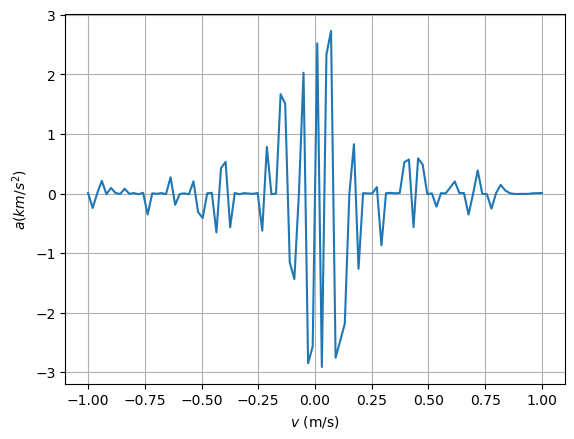

In [36]:
obe = pylcp.obe(MOT_Beams_split_H(150e6,-10e6), mag_field, hamiltonian_split,include_mag_forces=False, transform_into_re_im=False)
R = np.linspace(-10/cm_unit, 10/cm_unit, 100)
v = np.linspace(-1/velocity_unit, 1/velocity_unit, 100)

obe.generate_force_profile([np.zeros(v.shape),np.zeros(v.shape),np.zeros(v.shape)],
                              [v,np.zeros(v.shape),np.zeros(v.shape)],
                           name='Frad2', progress_bar=True, itermax=200, rel=1e-3,deltat_tmax=50/gammasim, deltat=50/gammasim, debug=False, Npts=2001)


fig, ax = plt.subplots(1, 1)

colormesh = ax.plot(v*velocity_unit, obe.profile['Frad2'].F[0]*F_unit*1e-3/(46*1.66e-27))
ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$a(km/s^2)$')
ylim = ax.get_ylim()
ax.grid()
fig.subplots_adjust(left=0.12,right=0.9)

In [15]:
init_vx = lambda T : np.random.normal(0, np.sqrt(1.380e-23*T/(87*1.66e-27)))

(array([  27.,  187.,  745., 1817., 2653., 2482., 1435.,  508.,  134.,
          12.]),
 array([-1.05465885, -0.83601789, -0.61737694, -0.39873598, -0.18009502,
         0.03854593,  0.25718689,  0.47582784,  0.6944688 ,  0.91310975,
         1.13175071]),
 <BarContainer object of 10 artists>)

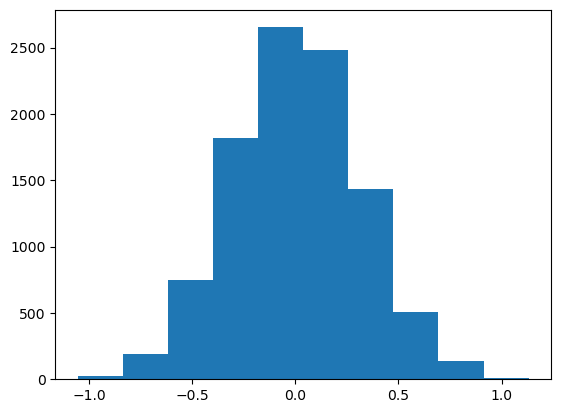

In [292]:
plt.hist([init_vx(0.001) for i in range(10000)])

In [18]:
from pylcp.common import progressBar
obe = pylcp.obe(MOT_Beams(150e6,-10e6), mag_field, hamiltonian,include_mag_forces=False, transform_into_re_im=False)
eqn = obe
#eqn = pylcp.rateeq(MOT_Beams_nov1(-2*np.pi*43e6/Hz_unit,0,1,2*np.pi*205e6/Hz_unit), mag_field, hamiltonian,include_mag_forces=False)
N_atom = 1
v_final = np.zeros((N_atom,))
#num_of_scatters = np.zeros((N_atom,), dtype='int')
#num_of_steps = np.zeros((N_atom,), dtype='int')

Rsc = gamma/2
runtime = 2e-4#10*87*1.66e-27*gamma/(2*(k**2)*Rsc*const.hbar)

fig, ax = plt.subplots(1, 1)
sols = []
progress = progressBar()
for ii in range(N_atom):
    eqn.set_initial_position_and_velocity(np.array([0., 0., 0.]), np.array([0*init_vx(5e-4), 0., 0.]))
    if isinstance(eqn, pylcp.rateeq):
        eqn.set_initial_pop_from_equilibrium()
    elif isinstance(eqn, pylcp.obe):
        eqn.set_initial_rho_from_rateeq()

    eqn.evolve_motion([0., runtime/t_unit],
                      max_step=1e-2/t_unit,
                      random_recoil=True,
                      max_scatter_probability=0.25,
                      freeze_axis=[False, True, True],
                      rtol=1e-4,
                      atol=np.concatenate(([1e-5]*16*16,[1e-3/velocity_unit,1e-3/velocity_unit,1e-3/velocity_unit,1e-2/cm_unit,1e-2/cm_unit,1e-2/cm_unit])),
                      method="RK23",
                      progress_bar=True)
    progress.update((ii+1.)/N_atom)

    if ii<10:
        ax.plot(eqn.sol.t*t_unit, eqn.sol.v[0]*velocity_unit)

    v_final[ii] = eqn.sol.v[0, -1]

    sols.append(eqn.sol)
    #num_of_scatters[ii] = sum(eqn.sol.n_random)
    #num_of_steps[ii] = len(eqn.sol.t)

ax.set_xlabel('t [s]')
ax.set_ylabel('v [m/s]')

In [40]:
v_final = [eqn.sol.v[0], eqn.sol.v[1], eqn.sol.v[2], eqn.sol.t, [runtime*0.999<eqn.sol.t[-1], len(eqn.sol.t_random)]]

In [41]:
v_final

[array([-0.00000000e+00,  3.44880231e-09,  1.24353094e-07, ...,
         2.69336227e-05,  2.69410051e-05,  2.69532095e-05]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.00000000e+00, 5.17049213e-03, 3.15821247e-02, ...,
        7.21521569e+01, 7.22252152e+01, 7.22569457e+01]),
 [True, 0]]

In [321]:
v_finals = [v_final[0]]

In [308]:
obe.recoil_velocity

{'X(v=0)->A(v=0)': 0.001995942481065007}

In [109]:
print(1000/gamma)
print(runtime)

2.7679e-05
219231129984722.75


In [114]:
sols[0].message

'Required step size is less than spacing between numbers.'

In [314]:
sols[0].t_random*t_unit

array([2.16418064e-08])

In [163]:
cm_unit

0.0036207749553406185

In [48]:
1e-4

0.0001

In [62]:
v_final=v_final*velocity_unit

In [64]:
import lmfit
from scipy.stats import iqr
#print(2*np.std(v_final)**2*mass)
def normaldist(x, mu, sigma, dx):
    # Gaussian probability distribution function
    # probability of landing in a bin of width dx is p(x)dx
    return dx/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/2/sigma**2)

def lett_temperature(s, delta):
    """
    Returns the ratio of the expected temperature relative to the "bare" Doppler temperature.
    """
    return 0.5*(1+2*s+4*delta**2)/2/np.abs(delta)

def fit_vfinal(v_final, N_atom):
    dx = 2*iqr(v_final)/N_atom**(1/3)
    xb = np.arange(dx/2, 1.1*np.amax(np.abs(v_final)), dx)
    xb = np.concatenate((-xb[::-1], xb))

    x = xb[:-1] + np.diff(xb)/2
    y = np.histogram(v_final, bins=xb)[0]/N_atom #Probability of an atom landing in this bin.'

    ok = (y>0)
    weights = np.zeros(ok.shape)
    weights[ok] = 1./np.sqrt(y[ok]/N_atom)
    model = lmfit.Model(normaldist)
    params = model.make_params()
    params['dx'].value = dx # bin width, probability of landing in the bin is p(x) dx
    params['dx'].vary = False
    params['mu'].value = 0.
    params['mu'].vary = False
    params['sigma'].value = np.std(v_final)

    result = model.fit(y[ok], params, x=x[ok], weights=weights[ok])

    return result, x, y, dx

result, x, y, dx = fit_vfinal(v_final, N_atom)

fig, ax = plt.subplots(1, 1)

ax.bar(x, y, width=0.8*dx, yerr=np.sqrt(y/N_atom)) #Poissonian error

x_fit = np.linspace(-1.1*np.amax(np.abs(v_final)), 1.1*np.amax(np.abs(v_final)), 101)

ax.plot(x_fit, result.eval(x=x_fit))
ax.plot(x_fit, normaldist(x_fit, 0, np.sqrt(lett_temperature(0.3*6, 0.5)/2/46*1.66e-27), dx))

ax.set_ylabel('$p(v_{\\rm final}) dx$')
ax.set_xlabel('$v_{\\rm final}/(\Gamma/k)$');

C:\Users\LP618\AppData\Local\Temp\ipykernel_25008\2524866630.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  xb = np.arange(dx/2, 1.1*np.amax(np.abs(v_final)), dx)


ValueError: Maximum allowed size exceeded